# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 pre-selected sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                             # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")
        
        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11685
EM iteration 50, llf=-11437, convergence criterion=1.7824e-06
EM converged at iteration 66, llf=-11436, convergence criterion=9.8972e-07 < tolerance=1e-06
EM start iterations, llf=-11698
EM iteration 50, llf=-11449, convergence criterion=1.7802e-06
EM converged at iteration 66, llf=-11449, convergence criterion=9.8844e-07 < tolerance=1e-06
EM start iterations, llf=-11751
EM iteration 50, llf=-11500, convergence criterion=1.7784e-06
EM converged at iteration 66, llf=-11499, convergence criterion=9.872e-07 < tolerance=1e-06
EM start iterations, llf=-11759
EM iteration 50, llf=-11508, convergence criterion=1.7666e-06
EM converged at iteration 66, llf=-11508, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-11829
EM iteration 50, llf=-11573, convergence criterion=1.7487e-06
EM converged at iteration 66, llf=-11572, convergence criterion=9.7146e-07 < tolerance=1e-06
EM start iterations, llf=-11837
EM iteration 50, llf=-11580, conve

EM converged at iteration 43, llf=-12474, convergence criterion=9.7478e-07 < tolerance=1e-06
EM start iterations, llf=-12737
EM converged at iteration 44, llf=-12526, convergence criterion=9.5644e-07 < tolerance=1e-06
EM start iterations, llf=-12746
EM converged at iteration 48, llf=-12537, convergence criterion=9.656e-07 < tolerance=1e-06
EM start iterations, llf=-12799
EM converged at iteration 48, llf=-12586, convergence criterion=9.7522e-07 < tolerance=1e-06
EM start iterations, llf=-12808
EM converged at iteration 48, llf=-12596, convergence criterion=9.7204e-07 < tolerance=1e-06
EM start iterations, llf=-12862
EM converged at iteration 48, llf=-12650, convergence criterion=9.6569e-07 < tolerance=1e-06
EM start iterations, llf=-12862
EM converged at iteration 48, llf=-12650, convergence criterion=9.6569e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM converged at iteration 47, llf=-12663, convergence criterion=9.8878e-07 < tolerance=1e-06
EM start iterations, llf=-12932
E

EM start iterations, llf=-14390
EM converged at iteration 48, llf=-14188, convergence criterion=9.8056e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM converged at iteration 47, llf=-14235, convergence criterion=9.9752e-07 < tolerance=1e-06
EM start iterations, llf=-14449
EM converged at iteration 47, llf=-14250, convergence criterion=9.6168e-07 < tolerance=1e-06
EM start iterations, llf=-14502
EM converged at iteration 46, llf=-14303, convergence criterion=9.862e-07 < tolerance=1e-06
EM start iterations, llf=-14502
EM converged at iteration 46, llf=-14303, convergence criterion=9.862e-07 < tolerance=1e-06
EM start iterations, llf=-14509
EM converged at iteration 46, llf=-14310, convergence criterion=9.8875e-07 < tolerance=1e-06
EM start iterations, llf=-14558
EM converged at iteration 47, llf=-14357, convergence criterion=9.6344e-07 < tolerance=1e-06
EM start iterations, llf=-14566
EM converged at iteration 47, llf=-14365, convergence criterion=9.5935e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16158
EM converged at iteration 44, llf=-15931, convergence criterion=9.6311e-07 < tolerance=1e-06
EM start iterations, llf=-16158
EM converged at iteration 44, llf=-15931, convergence criterion=9.6311e-07 < tolerance=1e-06
EM start iterations, llf=-16169
EM converged at iteration 44, llf=-15944, convergence criterion=9.5715e-07 < tolerance=1e-06
EM start iterations, llf=-16218
EM converged at iteration 44, llf=-15991, convergence criterion=9.5907e-07 < tolerance=1e-06
EM start iterations, llf=-16225
EM converged at iteration 40, llf=-15997, convergence criterion=9.5403e-07 < tolerance=1e-06
EM start iterations, llf=-16281
EM converged at iteration 39, llf=-16054, convergence criterion=9.8317e-07 < tolerance=1e-06
EM start iterations, llf=-16288
EM converged at iteration 39, llf=-16058, convergence criterion=9.8848e-07 < tolerance=1e-06
EM start iterations, llf=-16341
EM converged at iteration 39, llf=-16109, convergence criterion=9.9045e-07 < tolerance=1e-06


EM start iterations, llf=-17858
EM converged at iteration 38, llf=-17611, convergence criterion=9.9484e-07 < tolerance=1e-06
EM start iterations, llf=-17870
EM converged at iteration 39, llf=-17622, convergence criterion=9.5524e-07 < tolerance=1e-06
EM start iterations, llf=-17922
EM converged at iteration 39, llf=-17673, convergence criterion=9.6065e-07 < tolerance=1e-06
EM start iterations, llf=-17930
EM converged at iteration 39, llf=-17682, convergence criterion=9.5713e-07 < tolerance=1e-06
EM start iterations, llf=-17976
EM converged at iteration 39, llf=-17728, convergence criterion=9.5549e-07 < tolerance=1e-06
EM start iterations, llf=-17976
EM converged at iteration 39, llf=-17728, convergence criterion=9.5549e-07 < tolerance=1e-06
EM start iterations, llf=-17989
EM converged at iteration 38, llf=-17741, convergence criterion=9.9445e-07 < tolerance=1e-06
EM start iterations, llf=-18045
EM converged at iteration 38, llf=-17797, convergence criterion=9.8115e-07 < tolerance=1e-06


EM start iterations, llf=-11758
EM iteration 50, llf=-11505, convergence criterion=2.6672e-06
EM converged at iteration 81, llf=-11504, convergence criterion=9.8236e-07 < tolerance=1e-06
EM start iterations, llf=-11828
EM iteration 50, llf=-11569, convergence criterion=2.6196e-06
EM converged at iteration 80, llf=-11569, convergence criterion=9.9104e-07 < tolerance=1e-06
EM start iterations, llf=-11836
EM iteration 50, llf=-11576, convergence criterion=2.6091e-06
EM converged at iteration 80, llf=-11576, convergence criterion=9.8716e-07 < tolerance=1e-06
EM start iterations, llf=-11891
EM iteration 50, llf=-11632, convergence criterion=2.6209e-06
EM converged at iteration 80, llf=-11632, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-11891
EM iteration 50, llf=-11632, convergence criterion=2.6209e-06
EM converged at iteration 80, llf=-11632, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-11896
EM iteration 50, llf=-11637, conv

EM start iterations, llf=-12602
EM iteration 50, llf=-12384, convergence criterion=1.3648e-06
EM converged at iteration 59, llf=-12384, convergence criterion=9.6566e-07 < tolerance=1e-06
EM start iterations, llf=-12667
EM iteration 50, llf=-12456, convergence criterion=1.3731e-06
EM converged at iteration 59, llf=-12456, convergence criterion=9.7897e-07 < tolerance=1e-06
EM start iterations, llf=-12667
EM iteration 50, llf=-12456, convergence criterion=1.3731e-06
EM converged at iteration 59, llf=-12456, convergence criterion=9.7897e-07 < tolerance=1e-06
EM start iterations, llf=-12678
EM iteration 50, llf=-12470, convergence criterion=1.3782e-06
EM converged at iteration 59, llf=-12470, convergence criterion=9.8672e-07 < tolerance=1e-06
EM start iterations, llf=-12733
EM iteration 50, llf=-12523, convergence criterion=1.4155e-06
EM converged at iteration 60, llf=-12522, convergence criterion=9.7687e-07 < tolerance=1e-06
EM start iterations, llf=-12743
EM iteration 50, llf=-12533, conv

EM start iterations, llf=-13774
EM iteration 50, llf=-13583, convergence criterion=2.0059e-06
EM converged at iteration 75, llf=-13583, convergence criterion=9.9836e-07 < tolerance=1e-06
EM start iterations, llf=-13784
EM iteration 50, llf=-13594, convergence criterion=2.0045e-06
EM converged at iteration 75, llf=-13594, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-13840
EM iteration 50, llf=-13648, convergence criterion=1.9756e-06
EM converged at iteration 75, llf=-13648, convergence criterion=9.7968e-07 < tolerance=1e-06
EM start iterations, llf=-13847
EM iteration 50, llf=-13654, convergence criterion=1.8777e-06
EM converged at iteration 73, llf=-13654, convergence criterion=9.7544e-07 < tolerance=1e-06
EM start iterations, llf=-13906
EM iteration 50, llf=-13711, convergence criterion=1.8459e-06
EM converged at iteration 72, llf=-13711, convergence criterion=9.7793e-07 < tolerance=1e-06
EM start iterations, llf=-13915
EM iteration 50, llf=-13722, conv

EM start iterations, llf=-14919
EM iteration 50, llf=-14716, convergence criterion=1.7151e-06
EM converged at iteration 71, llf=-14716, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-14932
EM iteration 50, llf=-14728, convergence criterion=1.7291e-06
EM converged at iteration 71, llf=-14728, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-14979
EM iteration 50, llf=-14775, convergence criterion=1.7306e-06
EM converged at iteration 71, llf=-14775, convergence criterion=9.993e-07 < tolerance=1e-06
EM start iterations, llf=-14986
EM iteration 50, llf=-14782, convergence criterion=1.7254e-06
EM converged at iteration 71, llf=-14782, convergence criterion=9.9227e-07 < tolerance=1e-06
EM start iterations, llf=-15032
EM iteration 50, llf=-14826, convergence criterion=1.7179e-06
EM converged at iteration 71, llf=-14826, convergence criterion=9.7844e-07 < tolerance=1e-06
EM start iterations, llf=-15032
EM iteration 50, llf=-14826, conve

EM start iterations, llf=-16093
EM iteration 50, llf=-15869, convergence criterion=1.4155e-06
EM converged at iteration 62, llf=-15869, convergence criterion=9.8427e-07 < tolerance=1e-06
EM start iterations, llf=-16101
EM iteration 50, llf=-15876, convergence criterion=1.4152e-06
EM converged at iteration 62, llf=-15876, convergence criterion=9.8213e-07 < tolerance=1e-06
EM start iterations, llf=-16154
EM iteration 50, llf=-15929, convergence criterion=1.4077e-06
EM converged at iteration 62, llf=-15929, convergence criterion=9.759e-07 < tolerance=1e-06
EM start iterations, llf=-16154
EM iteration 50, llf=-15929, convergence criterion=1.4077e-06
EM converged at iteration 62, llf=-15929, convergence criterion=9.759e-07 < tolerance=1e-06
EM start iterations, llf=-16165
EM iteration 50, llf=-15941, convergence criterion=1.4044e-06
EM converged at iteration 62, llf=-15941, convergence criterion=9.7653e-07 < tolerance=1e-06
EM start iterations, llf=-16215
EM iteration 50, llf=-15989, conver

EM start iterations, llf=-17248
EM iteration 50, llf=-17015, convergence criterion=1.1285e-06
EM converged at iteration 55, llf=-17014, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-17248
EM iteration 50, llf=-17015, convergence criterion=1.1285e-06
EM converged at iteration 55, llf=-17014, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-17268
EM iteration 50, llf=-17034, convergence criterion=1.1309e-06
EM converged at iteration 55, llf=-17034, convergence criterion=9.7499e-07 < tolerance=1e-06
EM start iterations, llf=-17320
EM iteration 50, llf=-17086, convergence criterion=1.1002e-06
EM converged at iteration 54, llf=-17086, convergence criterion=9.7796e-07 < tolerance=1e-06
EM start iterations, llf=-17328
EM iteration 50, llf=-17094, convergence criterion=1.1062e-06
EM converged at iteration 54, llf=-17094, convergence criterion=9.825e-07 < tolerance=1e-06
EM start iterations, llf=-17372
EM iteration 50, llf=-17137, conve

EM start iterations, llf=-18156
EM iteration 50, llf=-17903, convergence criterion=1.1123e-06
EM converged at iteration 54, llf=-17902, convergence criterion=9.7434e-07 < tolerance=1e-06
EM start iterations, llf=-18207
EM iteration 50, llf=-17952, convergence criterion=1.1089e-06
EM converged at iteration 54, llf=-17952, convergence criterion=9.7113e-07 < tolerance=1e-06
EM start iterations, llf=-18215
EM iteration 50, llf=-17960, convergence criterion=1.1358e-06
EM converged at iteration 54, llf=-17960, convergence criterion=9.9575e-07 < tolerance=1e-06
EM start iterations, llf=-18270
EM iteration 50, llf=-18013, convergence criterion=1.1417e-06
EM converged at iteration 55, llf=-18013, convergence criterion=9.6974e-07 < tolerance=1e-06
EM start iterations, llf=-18277
EM iteration 50, llf=-18021, convergence criterion=1.1422e-06
EM converged at iteration 55, llf=-18021, convergence criterion=9.7019e-07 < tolerance=1e-06
EM start iterations, llf=-18331
EM iteration 50, llf=-18073, conv

EM converged at iteration 78, llf=-11486, convergence criterion=9.9185e-07 < tolerance=1e-06
EM start iterations, llf=-11747
EM iteration 50, llf=-11495, convergence criterion=2.5602e-06
EM converged at iteration 78, llf=-11494, convergence criterion=9.9194e-07 < tolerance=1e-06
EM start iterations, llf=-11817
EM iteration 50, llf=-11559, convergence criterion=2.534e-06
EM converged at iteration 78, llf=-11559, convergence criterion=9.8455e-07 < tolerance=1e-06
EM start iterations, llf=-11825
EM iteration 50, llf=-11566, convergence criterion=2.5244e-06
EM converged at iteration 78, llf=-11566, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-11880
EM iteration 50, llf=-11622, convergence criterion=2.5135e-06
EM converged at iteration 77, llf=-11621, convergence criterion=9.9945e-07 < tolerance=1e-06
EM start iterations, llf=-11880
EM iteration 50, llf=-11622, convergence criterion=2.5135e-06
EM converged at iteration 77, llf=-11621, convergence criterion=9.

EM converged at iteration 59, llf=-12366, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-12596
EM iteration 50, llf=-12376, convergence criterion=1.3998e-06
EM converged at iteration 59, llf=-12376, convergence criterion=9.777e-07 < tolerance=1e-06
EM start iterations, llf=-12661
EM iteration 50, llf=-12449, convergence criterion=1.484e-06
EM converged at iteration 61, llf=-12449, convergence criterion=9.6708e-07 < tolerance=1e-06
EM start iterations, llf=-12661
EM iteration 50, llf=-12449, convergence criterion=1.484e-06
EM converged at iteration 61, llf=-12449, convergence criterion=9.6708e-07 < tolerance=1e-06
EM start iterations, llf=-12672
EM iteration 50, llf=-12464, convergence criterion=1.5077e-06
EM converged at iteration 61, llf=-12464, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-12727
EM iteration 50, llf=-12516, convergence criterion=1.5271e-06
EM converged at iteration 61, llf=-12516, convergence criterion=9.944

EM converged at iteration 71, llf=-13577, convergence criterion=9.7285e-07 < tolerance=1e-06
EM start iterations, llf=-13763
EM iteration 50, llf=-13577, convergence criterion=1.9136e-06
EM converged at iteration 71, llf=-13577, convergence criterion=9.7285e-07 < tolerance=1e-06
EM start iterations, llf=-13774
EM iteration 50, llf=-13589, convergence criterion=1.9094e-06
EM converged at iteration 70, llf=-13588, convergence criterion=9.9834e-07 < tolerance=1e-06
EM start iterations, llf=-13830
EM iteration 50, llf=-13642, convergence criterion=1.8825e-06
EM converged at iteration 70, llf=-13642, convergence criterion=9.8493e-07 < tolerance=1e-06
EM start iterations, llf=-13837
EM iteration 50, llf=-13649, convergence criterion=1.7983e-06
EM converged at iteration 68, llf=-13648, convergence criterion=9.9838e-07 < tolerance=1e-06
EM start iterations, llf=-13896
EM iteration 50, llf=-13706, convergence criterion=1.8334e-06
EM converged at iteration 69, llf=-13705, convergence criterion=9

EM converged at iteration 67, llf=-14658, convergence criterion=9.9607e-07 < tolerance=1e-06
EM start iterations, llf=-14911
EM iteration 50, llf=-14711, convergence criterion=1.7473e-06
EM converged at iteration 67, llf=-14711, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-14923
EM iteration 50, llf=-14724, convergence criterion=1.7462e-06
EM converged at iteration 67, llf=-14723, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-14970
EM iteration 50, llf=-14770, convergence criterion=1.7464e-06
EM converged at iteration 67, llf=-14770, convergence criterion=9.9585e-07 < tolerance=1e-06
EM start iterations, llf=-14978
EM iteration 50, llf=-14777, convergence criterion=1.7378e-06
EM converged at iteration 67, llf=-14777, convergence criterion=9.9331e-07 < tolerance=1e-06
EM start iterations, llf=-15023
EM iteration 50, llf=-14821, convergence criterion=1.7236e-06
EM converged at iteration 67, llf=-14821, convergence criterion=9

EM converged at iteration 63, llf=-15814, convergence criterion=9.8984e-07 < tolerance=1e-06
EM start iterations, llf=-16084
EM iteration 50, llf=-15863, convergence criterion=1.5391e-06
EM converged at iteration 63, llf=-15863, convergence criterion=9.8232e-07 < tolerance=1e-06
EM start iterations, llf=-16091
EM iteration 50, llf=-15870, convergence criterion=1.537e-06
EM converged at iteration 63, llf=-15870, convergence criterion=9.8061e-07 < tolerance=1e-06
EM start iterations, llf=-16145
EM iteration 50, llf=-15923, convergence criterion=1.5317e-06
EM converged at iteration 63, llf=-15922, convergence criterion=9.771e-07 < tolerance=1e-06
EM start iterations, llf=-16145
EM iteration 50, llf=-15923, convergence criterion=1.5317e-06
EM converged at iteration 63, llf=-15922, convergence criterion=9.771e-07 < tolerance=1e-06
EM start iterations, llf=-16156
EM iteration 50, llf=-15935, convergence criterion=1.5336e-06
EM converged at iteration 63, llf=-15935, convergence criterion=9.78

EM converged at iteration 57, llf=-16961, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM iteration 50, llf=-17009, convergence criterion=1.2479e-06
EM converged at iteration 57, llf=-17009, convergence criterion=9.7795e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM iteration 50, llf=-17009, convergence criterion=1.2479e-06
EM converged at iteration 57, llf=-17009, convergence criterion=9.7795e-07 < tolerance=1e-06
EM start iterations, llf=-17258
EM iteration 50, llf=-17028, convergence criterion=1.2499e-06
EM converged at iteration 57, llf=-17028, convergence criterion=9.7911e-07 < tolerance=1e-06
EM start iterations, llf=-17310
EM iteration 50, llf=-17080, convergence criterion=1.2179e-06
EM converged at iteration 56, llf=-17080, convergence criterion=9.8756e-07 < tolerance=1e-06
EM start iterations, llf=-17318
EM iteration 50, llf=-17088, convergence criterion=1.2249e-06
EM converged at iteration 56, llf=-17088, convergence criterion=9

EM converged at iteration 56, llf=-17890, convergence criterion=9.8001e-07 < tolerance=1e-06
EM start iterations, llf=-18146
EM iteration 50, llf=-17895, convergence criterion=1.2146e-06
EM converged at iteration 56, llf=-17895, convergence criterion=9.8038e-07 < tolerance=1e-06
EM start iterations, llf=-18196
EM iteration 50, llf=-17944, convergence criterion=1.208e-06
EM converged at iteration 56, llf=-17944, convergence criterion=9.7487e-07 < tolerance=1e-06
EM start iterations, llf=-18205
EM iteration 50, llf=-17953, convergence criterion=1.2374e-06
EM converged at iteration 57, llf=-17953, convergence criterion=9.6726e-07 < tolerance=1e-06
EM start iterations, llf=-18259
EM iteration 50, llf=-18006, convergence criterion=1.2353e-06
EM converged at iteration 56, llf=-18006, convergence criterion=9.9857e-07 < tolerance=1e-06
EM start iterations, llf=-18267
EM iteration 50, llf=-18014, convergence criterion=1.2364e-06
EM converged at iteration 56, llf=-18014, convergence criterion=9.

EM start iterations, llf=-11269
EM iteration 50, llf=-11118, convergence criterion=1.3224e-06
EM converged at iteration 58, llf=-11118, convergence criterion=9.7635e-07 < tolerance=1e-06
EM start iterations, llf=-11278
EM iteration 50, llf=-11127, convergence criterion=1.2546e-06
EM converged at iteration 56, llf=-11127, convergence criterion=9.9566e-07 < tolerance=1e-06
EM start iterations, llf=-11341
EM iteration 50, llf=-11191, convergence criterion=1.2043e-06
EM converged at iteration 55, llf=-11191, convergence criterion=9.908e-07 < tolerance=1e-06
EM start iterations, llf=-11352
EM iteration 50, llf=-11200, convergence criterion=1.2075e-06
EM converged at iteration 55, llf=-11200, convergence criterion=9.9245e-07 < tolerance=1e-06
EM start iterations, llf=-11409
EM iteration 50, llf=-11253, convergence criterion=1.256e-06
EM converged at iteration 56, llf=-11253, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-11409
EM iteration 50, llf=-11253, conver

EM converged at iteration 33, llf=-12219, convergence criterion=9.4865e-07 < tolerance=1e-06
EM start iterations, llf=-12422
EM converged at iteration 33, llf=-12267, convergence criterion=9.7349e-07 < tolerance=1e-06
EM start iterations, llf=-12465
EM converged at iteration 33, llf=-12311, convergence criterion=9.4318e-07 < tolerance=1e-06
EM start iterations, llf=-12465
EM converged at iteration 33, llf=-12311, convergence criterion=9.4318e-07 < tolerance=1e-06
EM start iterations, llf=-12477
EM converged at iteration 33, llf=-12324, convergence criterion=9.474e-07 < tolerance=1e-06
EM start iterations, llf=-12508
EM converged at iteration 33, llf=-12354, convergence criterion=9.7062e-07 < tolerance=1e-06
EM start iterations, llf=-12516
EM converged at iteration 33, llf=-12359, convergence criterion=9.9915e-07 < tolerance=1e-06
EM start iterations, llf=-12573
EM converged at iteration 34, llf=-12409, convergence criterion=9.6692e-07 < tolerance=1e-06
EM start iterations, llf=-12578
E

EM start iterations, llf=-13946
EM converged at iteration 35, llf=-13777, convergence criterion=9.4471e-07 < tolerance=1e-06
EM start iterations, llf=-13951
EM converged at iteration 35, llf=-13784, convergence criterion=9.45e-07 < tolerance=1e-06
EM start iterations, llf=-13999
EM converged at iteration 34, llf=-13833, convergence criterion=9.9176e-07 < tolerance=1e-06
EM start iterations, llf=-14009
EM converged at iteration 34, llf=-13842, convergence criterion=9.7827e-07 < tolerance=1e-06
EM start iterations, llf=-14058
EM converged at iteration 34, llf=-13890, convergence criterion=9.6766e-07 < tolerance=1e-06
EM start iterations, llf=-14066
EM converged at iteration 34, llf=-13898, convergence criterion=9.7428e-07 < tolerance=1e-06
EM start iterations, llf=-14120
EM converged at iteration 34, llf=-13951, convergence criterion=9.771e-07 < tolerance=1e-06
EM start iterations, llf=-14120
EM converged at iteration 34, llf=-13951, convergence criterion=9.771e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-15610
EM converged at iteration 25, llf=-15434, convergence criterion=9.5867e-07 < tolerance=1e-06
EM start iterations, llf=-15662
EM converged at iteration 25, llf=-15485, convergence criterion=9.5475e-07 < tolerance=1e-06
EM start iterations, llf=-15670
EM converged at iteration 25, llf=-15494, convergence criterion=9.5131e-07 < tolerance=1e-06
EM start iterations, llf=-15714
EM converged at iteration 25, llf=-15538, convergence criterion=9.4849e-07 < tolerance=1e-06
EM start iterations, llf=-15714
EM converged at iteration 25, llf=-15538, convergence criterion=9.4849e-07 < tolerance=1e-06
EM start iterations, llf=-15728
EM converged at iteration 25, llf=-15551, convergence criterion=9.491e-07 < tolerance=1e-06
EM start iterations, llf=-15783
EM converged at iteration 25, llf=-15608, convergence criterion=9.6283e-07 < tolerance=1e-06
EM start iterations, llf=-15787
EM converged at iteration 25, llf=-15612, convergence criterion=9.7226e-07 < tolerance=1e-06
E

EM start iterations, llf=-17108
EM converged at iteration 26, llf=-16926, convergence criterion=9.9536e-07 < tolerance=1e-06
EM start iterations, llf=-17108
EM converged at iteration 26, llf=-16926, convergence criterion=9.9536e-07 < tolerance=1e-06
EM start iterations, llf=-17113
EM converged at iteration 26, llf=-16931, convergence criterion=9.8206e-07 < tolerance=1e-06
EM start iterations, llf=-17160
EM converged at iteration 26, llf=-16977, convergence criterion=9.642e-07 < tolerance=1e-06
EM start iterations, llf=-17175
EM converged at iteration 26, llf=-16992, convergence criterion=9.7306e-07 < tolerance=1e-06
EM start iterations, llf=-17229
EM converged at iteration 26, llf=-17044, convergence criterion=9.6822e-07 < tolerance=1e-06
EM start iterations, llf=-17235
EM converged at iteration 26, llf=-17050, convergence criterion=9.6647e-07 < tolerance=1e-06
EM start iterations, llf=-17288
EM converged at iteration 26, llf=-17104, convergence criterion=9.4683e-07 < tolerance=1e-06
E

EM iteration 50, llf=-11304, convergence criterion=1.6509e-06
EM converged at iteration 66, llf=-11304, convergence criterion=9.904e-07 < tolerance=1e-06
EM start iterations, llf=-11512
EM iteration 50, llf=-11350, convergence criterion=1.6679e-06
EM converged at iteration 67, llf=-11350, convergence criterion=9.8007e-07 < tolerance=1e-06
EM start iterations, llf=-11516
EM iteration 50, llf=-11355, convergence criterion=1.668e-06
EM converged at iteration 67, llf=-11355, convergence criterion=9.8108e-07 < tolerance=1e-06
EM start iterations, llf=-11557
EM iteration 50, llf=-11397, convergence criterion=1.5935e-06
EM converged at iteration 64, llf=-11397, convergence criterion=9.9646e-07 < tolerance=1e-06
EM start iterations, llf=-11557
EM iteration 50, llf=-11397, convergence criterion=1.5935e-06
EM converged at iteration 64, llf=-11397, convergence criterion=9.9646e-07 < tolerance=1e-06
EM start iterations, llf=-11566
EM iteration 50, llf=-11407, convergence criterion=1.5772e-06
EM co

EM start iterations, llf=-12616
EM converged at iteration 38, llf=-12458, convergence criterion=9.9396e-07 < tolerance=1e-06
EM start iterations, llf=-12656
EM converged at iteration 38, llf=-12499, convergence criterion=9.9982e-07 < tolerance=1e-06
EM start iterations, llf=-12664
EM converged at iteration 39, llf=-12506, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-12712
EM converged at iteration 39, llf=-12553, convergence criterion=9.7642e-07 < tolerance=1e-06
EM start iterations, llf=-12730
EM converged at iteration 40, llf=-12570, convergence criterion=9.6434e-07 < tolerance=1e-06
EM start iterations, llf=-12778
EM converged at iteration 39, llf=-12619, convergence criterion=9.7635e-07 < tolerance=1e-06
EM start iterations, llf=-12778
EM converged at iteration 39, llf=-12619, convergence criterion=9.7635e-07 < tolerance=1e-06
EM start iterations, llf=-12787
EM converged at iteration 39, llf=-12627, convergence criterion=9.798e-07 < tolerance=1e-06
E

EM start iterations, llf=-14223
EM converged at iteration 38, llf=-14058, convergence criterion=9.708e-07 < tolerance=1e-06
EM start iterations, llf=-14231
EM converged at iteration 38, llf=-14066, convergence criterion=9.7387e-07 < tolerance=1e-06
EM start iterations, llf=-14276
EM converged at iteration 38, llf=-14110, convergence criterion=9.7502e-07 < tolerance=1e-06
EM start iterations, llf=-14276
EM converged at iteration 38, llf=-14110, convergence criterion=9.7502e-07 < tolerance=1e-06
EM start iterations, llf=-14288
EM converged at iteration 38, llf=-14122, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-14332
EM converged at iteration 38, llf=-14166, convergence criterion=9.688e-07 < tolerance=1e-06
EM start iterations, llf=-14342
EM converged at iteration 37, llf=-14176, convergence criterion=9.7759e-07 < tolerance=1e-06
EM start iterations, llf=-14397
EM converged at iteration 37, llf=-14230, convergence criterion=9.7556e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15886
EM converged at iteration 27, llf=-15714, convergence criterion=9.8883e-07 < tolerance=1e-06
EM start iterations, llf=-15895
EM converged at iteration 28, llf=-15723, convergence criterion=9.456e-07 < tolerance=1e-06
EM start iterations, llf=-15946
EM converged at iteration 28, llf=-15773, convergence criterion=9.4817e-07 < tolerance=1e-06
EM start iterations, llf=-15958
EM converged at iteration 28, llf=-15785, convergence criterion=9.5001e-07 < tolerance=1e-06
EM start iterations, llf=-16003
EM converged at iteration 28, llf=-15829, convergence criterion=9.4122e-07 < tolerance=1e-06
EM start iterations, llf=-16013
EM converged at iteration 27, llf=-15840, convergence criterion=9.9683e-07 < tolerance=1e-06
EM start iterations, llf=-16063
EM converged at iteration 28, llf=-15888, convergence criterion=9.4722e-07 < tolerance=1e-06
EM start iterations, llf=-16063
EM converged at iteration 28, llf=-15888, convergence criterion=9.4722e-07 < tolerance=1e-06
E

EM start iterations, llf=-17341
EM converged at iteration 30, llf=-17158, convergence criterion=9.7413e-07 < tolerance=1e-06
EM start iterations, llf=-17392
EM converged at iteration 30, llf=-17209, convergence criterion=9.7001e-07 < tolerance=1e-06
EM start iterations, llf=-17399
EM converged at iteration 30, llf=-17215, convergence criterion=9.6643e-07 < tolerance=1e-06
EM start iterations, llf=-17451
EM converged at iteration 30, llf=-17267, convergence criterion=9.535e-07 < tolerance=1e-06
EM start iterations, llf=-17451
EM converged at iteration 30, llf=-17267, convergence criterion=9.535e-07 < tolerance=1e-06
EM start iterations, llf=-17459
EM converged at iteration 30, llf=-17275, convergence criterion=9.5893e-07 < tolerance=1e-06
EM start iterations, llf=-17515
EM converged at iteration 30, llf=-17331, convergence criterion=9.6298e-07 < tolerance=1e-06
EM start iterations, llf=-17520
EM converged at iteration 30, llf=-17337, convergence criterion=9.5208e-07 < tolerance=1e-06
EM

EM converged at iteration 56, llf=-11451, convergence criterion=9.8111e-07 < tolerance=1e-06
EM start iterations, llf=-11648
EM iteration 50, llf=-11491, convergence criterion=1.2266e-06
EM converged at iteration 57, llf=-11491, convergence criterion=9.7528e-07 < tolerance=1e-06
EM start iterations, llf=-11650
EM iteration 50, llf=-11493, convergence criterion=1.374e-06
EM converged at iteration 61, llf=-11493, convergence criterion=9.8486e-07 < tolerance=1e-06
EM start iterations, llf=-11719
EM iteration 50, llf=-11562, convergence criterion=1.4139e-06
EM converged at iteration 62, llf=-11562, convergence criterion=9.9874e-07 < tolerance=1e-06
EM start iterations, llf=-11719
EM iteration 50, llf=-11562, convergence criterion=1.4139e-06
EM converged at iteration 62, llf=-11562, convergence criterion=9.9874e-07 < tolerance=1e-06
EM start iterations, llf=-11732
EM iteration 50, llf=-11576, convergence criterion=1.2749e-06
EM converged at iteration 58, llf=-11576, convergence criterion=9.

EM converged at iteration 63, llf=-12253, convergence criterion=9.7497e-07 < tolerance=1e-06
EM start iterations, llf=-12448
EM iteration 50, llf=-12298, convergence criterion=1.4816e-06
EM converged at iteration 65, llf=-12298, convergence criterion=9.8063e-07 < tolerance=1e-06
EM start iterations, llf=-12448
EM iteration 50, llf=-12298, convergence criterion=1.4816e-06
EM converged at iteration 65, llf=-12298, convergence criterion=9.8063e-07 < tolerance=1e-06
EM start iterations, llf=-12461
EM iteration 50, llf=-12311, convergence criterion=1.4909e-06
EM converged at iteration 65, llf=-12310, convergence criterion=9.8653e-07 < tolerance=1e-06
EM start iterations, llf=-12493
EM iteration 50, llf=-12342, convergence criterion=1.4414e-06
EM converged at iteration 63, llf=-12342, convergence criterion=9.9902e-07 < tolerance=1e-06
EM start iterations, llf=-12502
EM iteration 50, llf=-12347, convergence criterion=1.4723e-06
EM converged at iteration 64, llf=-12347, convergence criterion=9

EM converged at iteration 59, llf=-13242, convergence criterion=9.836e-07 < tolerance=1e-06
EM start iterations, llf=-13410
EM iteration 50, llf=-13247, convergence criterion=1.3048e-06
EM converged at iteration 59, llf=-13247, convergence criterion=9.822e-07 < tolerance=1e-06
EM start iterations, llf=-13464
EM iteration 50, llf=-13301, convergence criterion=1.3037e-06
EM converged at iteration 59, llf=-13301, convergence criterion=9.7355e-07 < tolerance=1e-06
EM start iterations, llf=-13471
EM iteration 50, llf=-13308, convergence criterion=1.2787e-06
EM converged at iteration 58, llf=-13308, convergence criterion=9.8345e-07 < tolerance=1e-06
EM start iterations, llf=-13519
EM iteration 50, llf=-13357, convergence criterion=1.2889e-06
EM converged at iteration 58, llf=-13356, convergence criterion=9.8579e-07 < tolerance=1e-06
EM start iterations, llf=-13528
EM iteration 50, llf=-13366, convergence criterion=1.2524e-06
EM converged at iteration 57, llf=-13366, convergence criterion=9.8

EM converged at iteration 53, llf=-14358, convergence criterion=9.7649e-07 < tolerance=1e-06
EM start iterations, llf=-14534
EM iteration 50, llf=-14368, convergence criterion=1.0991e-06
EM converged at iteration 53, llf=-14368, convergence criterion=9.8678e-07 < tolerance=1e-06
EM start iterations, llf=-14587
EM iteration 50, llf=-14420, convergence criterion=1.0478e-06
EM converged at iteration 52, llf=-14420, convergence criterion=9.7354e-07 < tolerance=1e-06
EM start iterations, llf=-14594
EM iteration 50, llf=-14427, convergence criterion=1.0524e-06
EM converged at iteration 52, llf=-14427, convergence criterion=9.7802e-07 < tolerance=1e-06
EM start iterations, llf=-14641
EM iteration 50, llf=-14477, convergence criterion=1.0639e-06
EM converged at iteration 52, llf=-14477, convergence criterion=9.8974e-07 < tolerance=1e-06
EM start iterations, llf=-14641
EM iteration 50, llf=-14477, convergence criterion=1.0639e-06
EM converged at iteration 52, llf=-14477, convergence criterion=9

EM start iterations, llf=-15818
EM converged at iteration 47, llf=-15647, convergence criterion=9.9773e-07 < tolerance=1e-06
EM start iterations, llf=-15825
EM converged at iteration 47, llf=-15654, convergence criterion=9.9065e-07 < tolerance=1e-06
EM start iterations, llf=-15877
EM converged at iteration 48, llf=-15706, convergence criterion=9.7183e-07 < tolerance=1e-06
EM start iterations, llf=-15877
EM converged at iteration 48, llf=-15706, convergence criterion=9.7183e-07 < tolerance=1e-06
EM start iterations, llf=-15886
EM converged at iteration 48, llf=-15714, convergence criterion=9.6518e-07 < tolerance=1e-06
EM start iterations, llf=-15937
EM converged at iteration 48, llf=-15764, convergence criterion=9.8247e-07 < tolerance=1e-06
EM start iterations, llf=-15949
EM converged at iteration 48, llf=-15776, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-15994
EM converged at iteration 47, llf=-15820, convergence criterion=9.8173e-07 < tolerance=1e-06


EM iteration 50, llf=-16876, convergence criterion=9.9978e-07
EM converged at iteration 50, llf=-16876, convergence criterion=9.9978e-07 < tolerance=1e-06
EM start iterations, llf=-17065
EM iteration 50, llf=-16882, convergence criterion=9.9423e-07
EM converged at iteration 50, llf=-16882, convergence criterion=9.9423e-07 < tolerance=1e-06
EM start iterations, llf=-17110
EM iteration 50, llf=-16927, convergence criterion=1.0072e-06
EM converged at iteration 51, llf=-16927, convergence criterion=9.7491e-07 < tolerance=1e-06
EM start iterations, llf=-17110
EM iteration 50, llf=-16927, convergence criterion=1.0072e-06
EM converged at iteration 51, llf=-16927, convergence criterion=9.7491e-07 < tolerance=1e-06
EM start iterations, llf=-17123
EM iteration 50, llf=-16939, convergence criterion=1.0091e-06
EM converged at iteration 51, llf=-16939, convergence criterion=9.7673e-07 < tolerance=1e-06
EM start iterations, llf=-17178
EM iteration 50, llf=-16993, convergence criterion=1.0135e-06
EM 

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


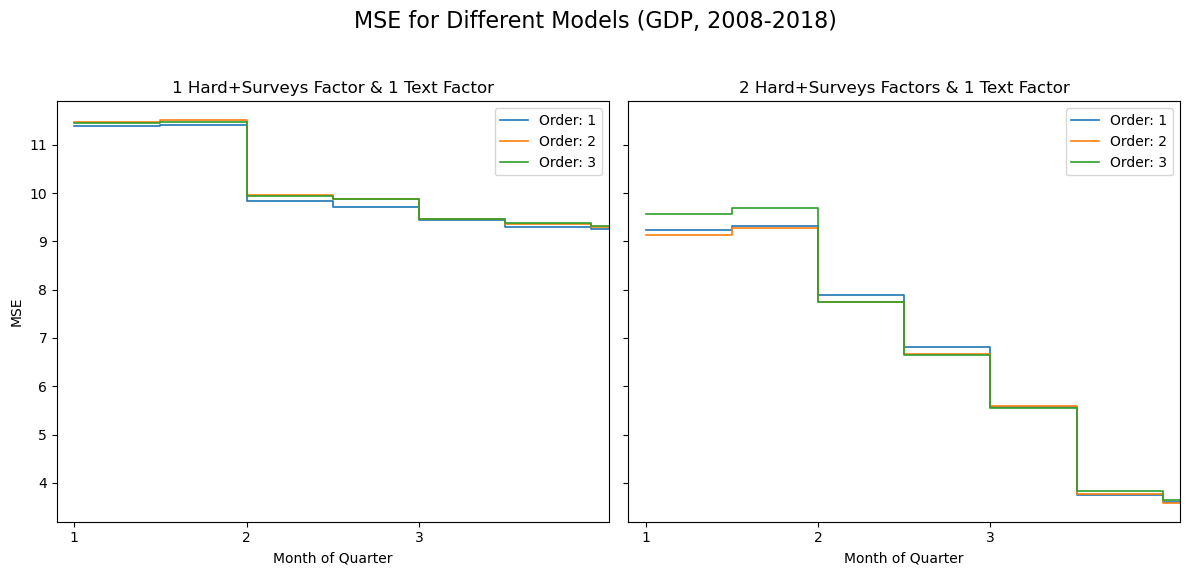

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


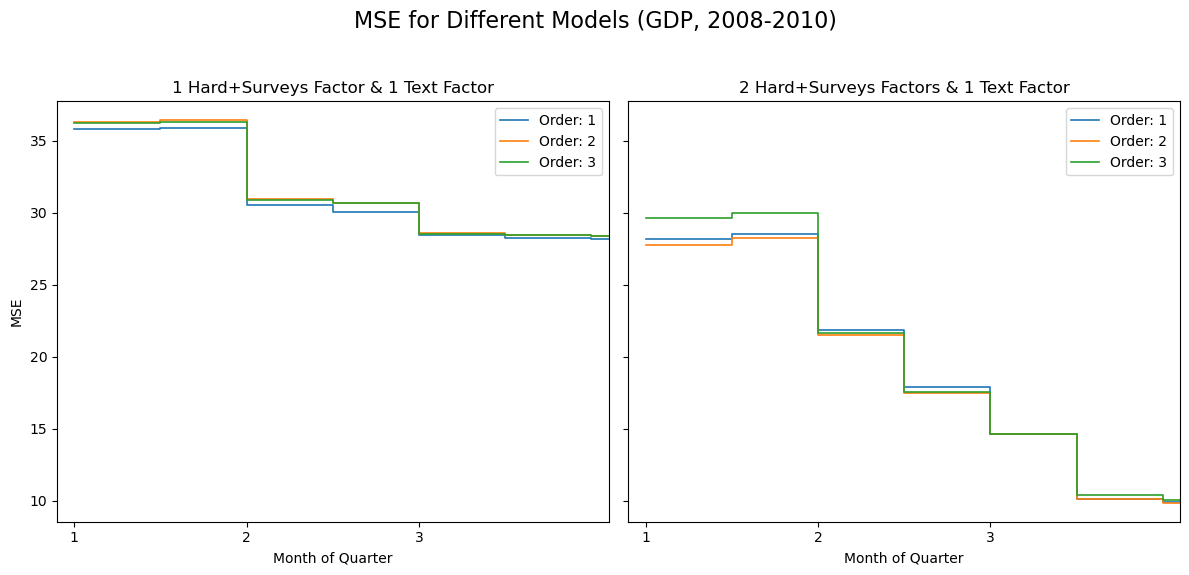

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


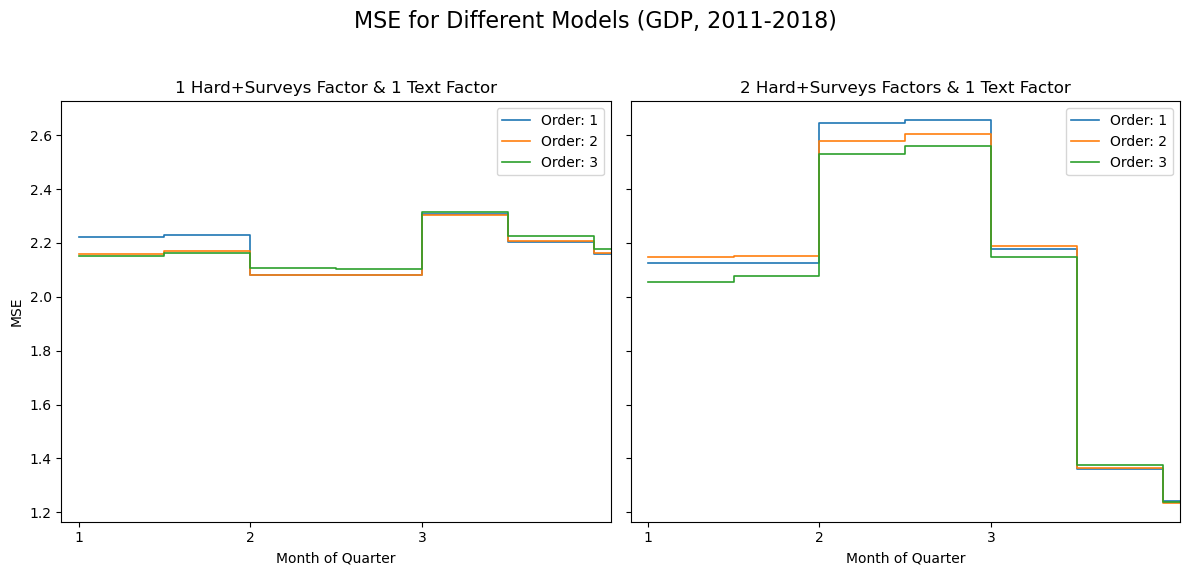

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


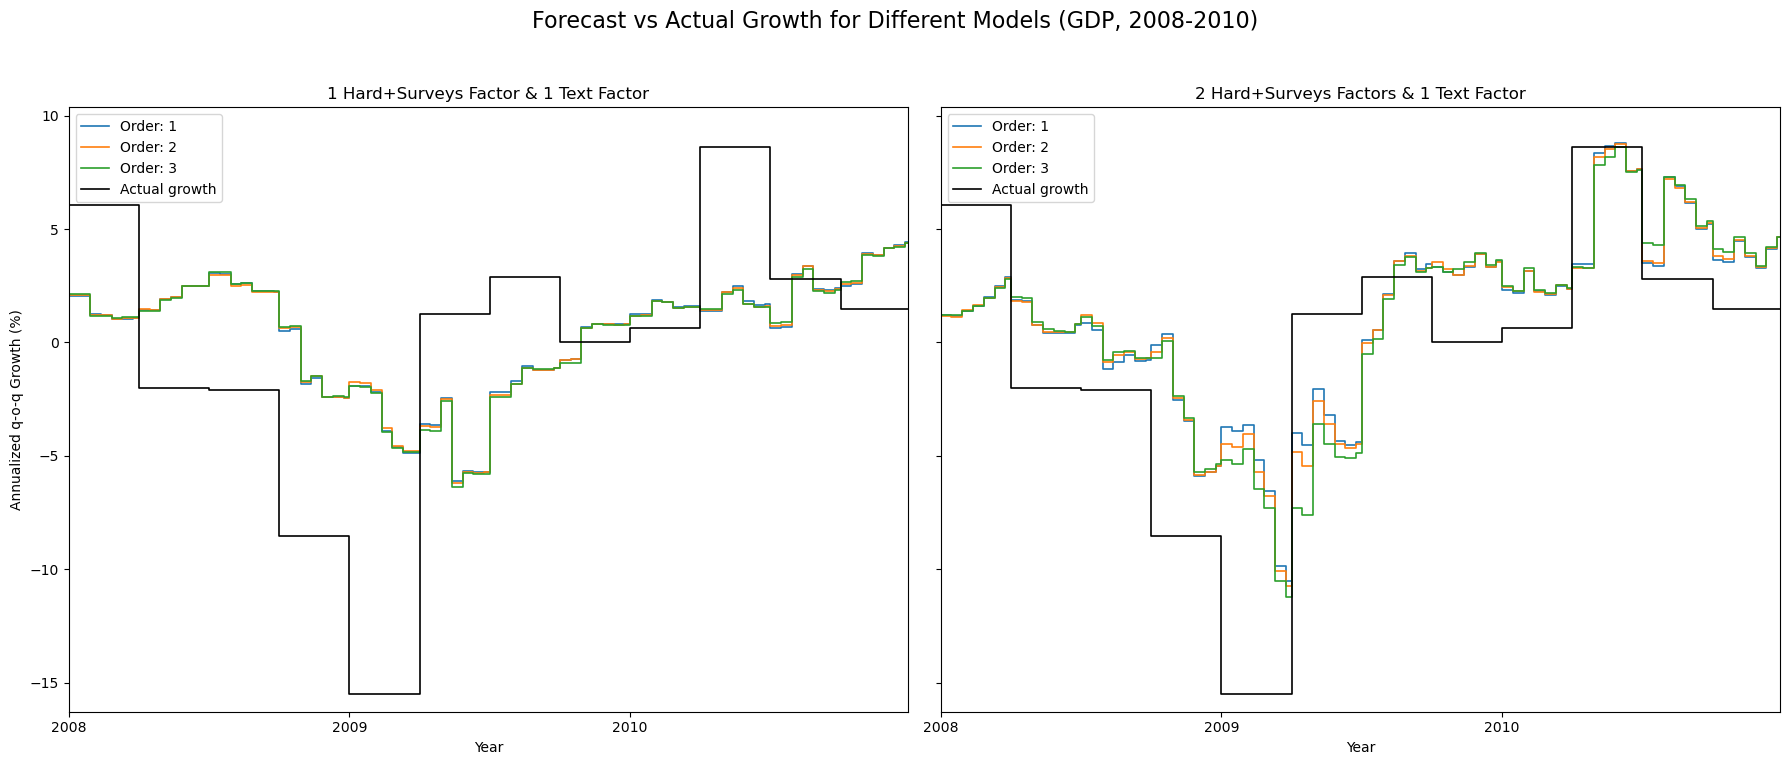

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


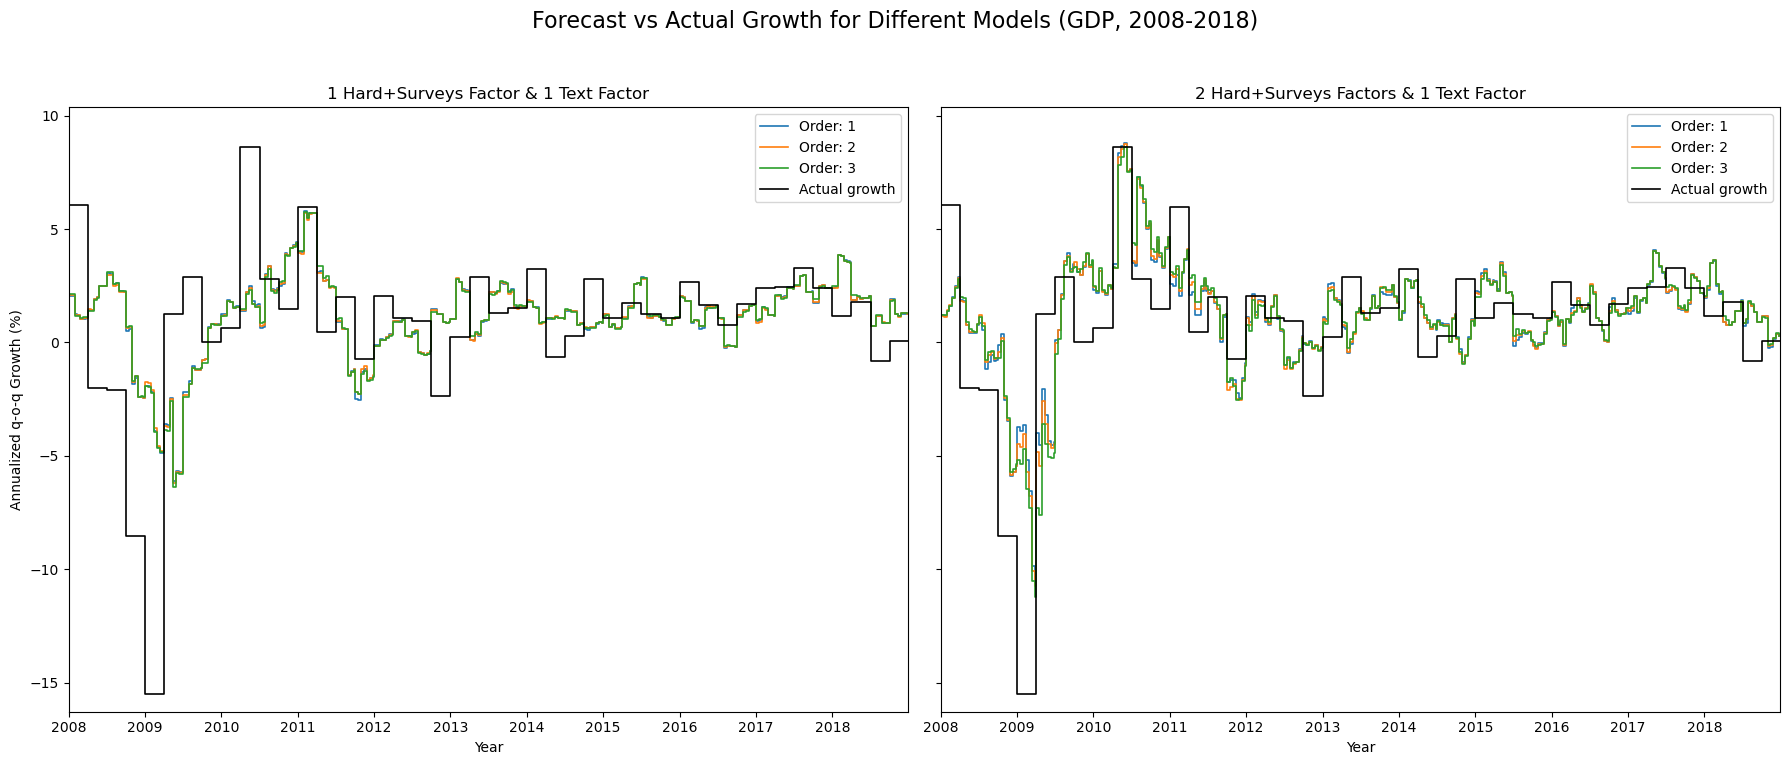

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


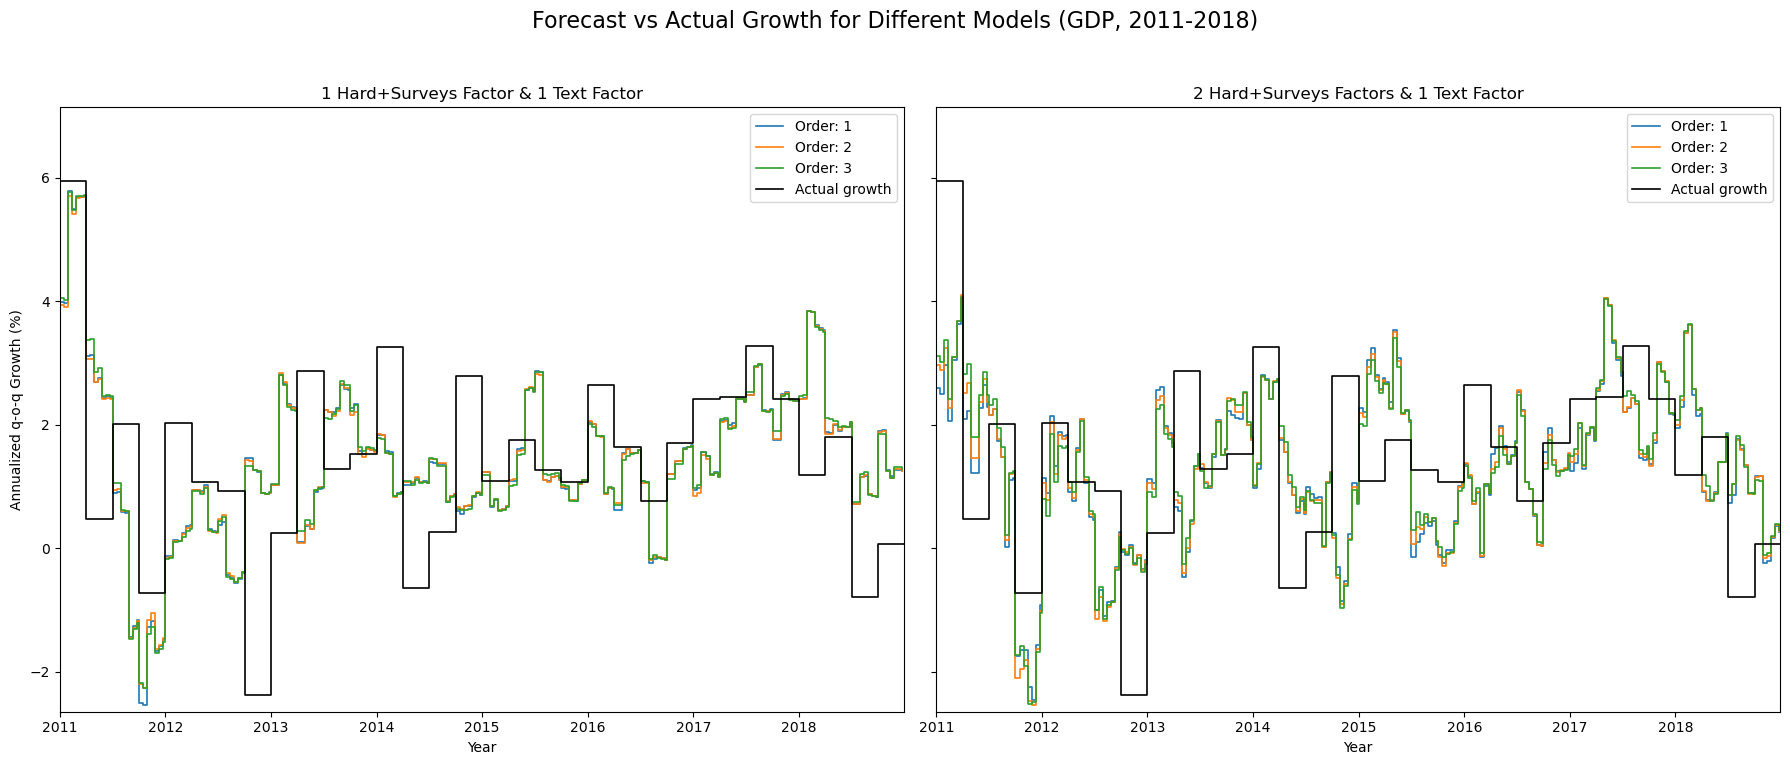

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()